#**I. DATA PREPARATION**

In [1]:
# Show all outcome of a cell
from IPython import get_ipython
get_ipython().ast_node_interactivity = 'all'

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For processing
from pandas.plotting import scatter_matrix
import warnings
warnings.filterwarnings('ignore')

# For modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay


In [3]:
# Mount Google Drive to Collab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Load the dataset and show the first 5 lines
df = pd.read_csv('/content/drive/MyDrive/customer_churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Choose rows 3000-7000 from the dataset
# df = df0.iloc[3000:7001]

#**II. EDA AND VISUALIZATION**

##1. General Data Processing

In [7]:
# Overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


From the table above, we realize some "strange" things:

- SeniorCitizen has the data type of "int64"

=> We should **convert it into object/ boolean** type

- TotalCharges has the data type of "object"

=> We need to **convert it into numerical** type and check if the coversion results in any **missing values**

- There are **too many "object" type** while they can be treated as **categorical**.

=> However, we can solve it by **encoding** later in the section.

In [8]:
# Convert SeniorCitizen from int64 to categorical
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')

# Convert TotalCharges from object to numerical type
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [9]:
# Double check data type and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [10]:
# Check for duplicated values
df_duplicated = df.duplicated().sum()
print(df_duplicated)

0


From the tables, we know that

- There is **no duplicated** value
- There are **6 missing** values in TotalCharges
- We have **not checked for outliers**

=> Next step is to investigate the **data and distribution** so that we know how to deal with such errors

In [11]:
# Check the records where TotalCharges is null
df[df['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [12]:
# Check how many customer churned
df['Churn'].value_counts()
df['Churn'].value_counts(normalize=True)

,count
Churn,
No,5174
Yes,1869


,proportion
Churn,
No,0.73463
Yes,0.26537


There are two reasons why the 6 missing values will be dismissed

- The number of missing values is very small (6 out of 4001 records, ~0,15%)
- The Churn column = "No", meaning that these customer didn't churn. Our target is to discover the patterns for churning, and the "No" record for churn is a lot (2924 records, occupying ~73% of the dataset)

=> We will just simply drop the missing values

In [13]:
# Drop the missing values
df.dropna(inplace=True)
df.isnull().sum() #Recheck

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


,0
tenure,"Axes(0.125,0.53;0.168478x0.35)"
MonthlyCharges,"Axes(0.327174,0.53;0.168478x0.35)"
TotalCharges,"Axes(0.529348,0.53;0.168478x0.35)"


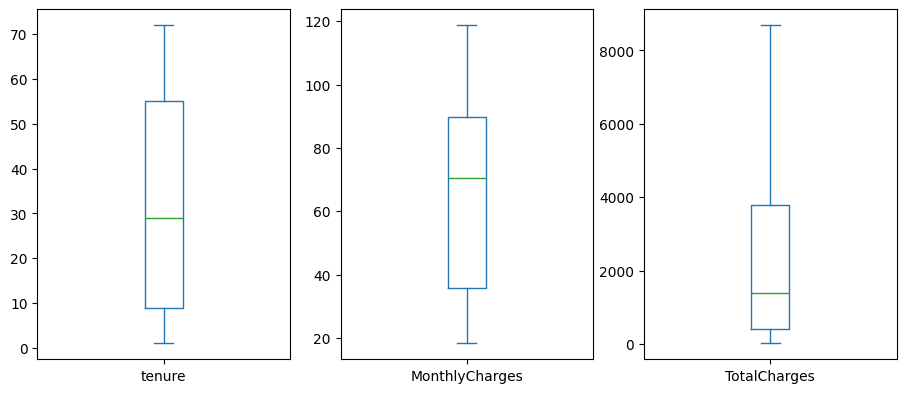

In [14]:
# Check for data distribution
df.describe()

# Visualize data distribution
df.plot(kind='box', subplots=True, layout=(2,4), figsize=(15,10))
plt.show()

Overall, there is **no significant outliers**.

However, the data is **skewed** to some extend, so **standardizing** the data might benefits us later, especially when we want to use the **Logistic Regression** model

##2. More Advanced Data Processing

###a. Check Redundancy and Correlation

In [15]:
# Drop unimportant column: CustomerID
df.drop('customerID', axis=1, inplace=True)

<Figure size 1200x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix (Numeric Features Only)')

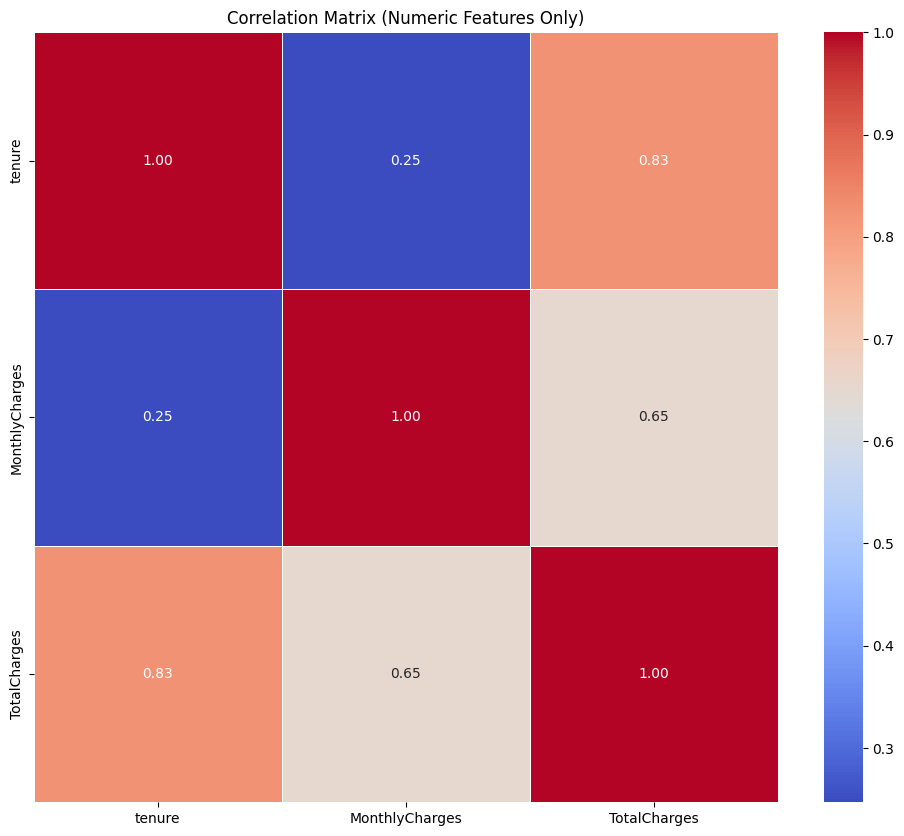

In [16]:
# Compute correlation matrix for numeric columns
df_numeric = df.select_dtypes(include=['int64', 'float64'])

corr_matrix = df_numeric.corr()

# Visualize the correlation
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix (Numeric Features Only)")
plt.show()

In [17]:
# Check if "StreamingTV" and "StreamingMovie" are redundant

df_encoded = df.copy()
df_encoded['StreamingTV'] = df_encoded['StreamingTV'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
df_encoded['StreamingMovies'] = df_encoded['StreamingMovies'].map({'Yes': 1, 'No': 0, 'No internet service': 0})

df_encoded[['StreamingTV', 'StreamingMovies']].corr()

,StreamingTV,StreamingMovies
StreamingTV,1.00000,0.53338
StreamingMovies,0.53338,1.00000


=> They are **not redundant** due to the low correlation coefficient

###b. Create Pipelines for Processing and Modeling

In [18]:
# Separate features and target
y = np.c_[df['Churn']] # target
X = df.drop('Churn', axis = 1) # features

# Check the dimensions
print(X.shape)
print(y.shape)

(7032, 19)
(7032, 1)


In [19]:
# Identify column types
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

In [20]:
# Creat pipeline for numerical columns
num_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())                    # standardize
])

# Create pipeline for categorical columns
cat_pipeline = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))    # one-hot encode
])

In [21]:
# Full pipeline
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [22]:
# Get encoded matrix
X_encoded = preprocessor.fit_transform(X)

# Get feature names (OneHotEncoder part only)
encoded_cat_names = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_features)
all_feature_names = list(num_features) + list(encoded_cat_names)

In [23]:
# Build encoded DataFrame
X_encoded_df = pd.DataFrame(X_encoded, columns=all_feature_names)
y_flat = pd.Series(y.flatten()).map({'Yes': 1, 'No': 0})
X_encoded_df['Churn'] = y_flat

In [24]:
# Get correlation of each feature with 'Churn'
correlations = X_encoded_df.corr()['Churn'].drop('Churn').sort_values(ascending=False)

print("Top 10 features positively correlated with Churn:")
print(correlations.head(10))
print()
print("Top 10 features negatively correlated with Churn:")
print(correlations.tail(10))

Top 10 features positively correlated with Churn:
Contract_Month-to-month           0.404565
OnlineSecurity_No                 0.342235
TechSupport_No                    0.336877
InternetService_Fiber optic       0.307463
PaymentMethod_Electronic check    0.301455
OnlineBackup_No                   0.267595
DeviceProtection_No               0.252056
MonthlyCharges                    0.192858
PaperlessBilling_Yes              0.191454
Dependents_No                     0.163128
Name: Churn, dtype: float64

Top 10 features negatively correlated with Churn:
TotalCharges                           -0.199484
TechSupport_No internet service        -0.227578
InternetService_No                     -0.227578
DeviceProtection_No internet service   -0.227578
OnlineBackup_No internet service       -0.227578
OnlineSecurity_No internet service     -0.227578
StreamingMovies_No internet service    -0.227578
StreamingTV_No internet service        -0.227578
Contract_Two year                      -0.301552


<Figure size 1000x800 with 0 Axes>

<Axes: ylabel='None'>

Text(0.5, 1.0, 'Feature Correlation with Churn')

Text(0.5, 0, 'Correlation Coefficient')

Text(0, 0.5, 'Features')

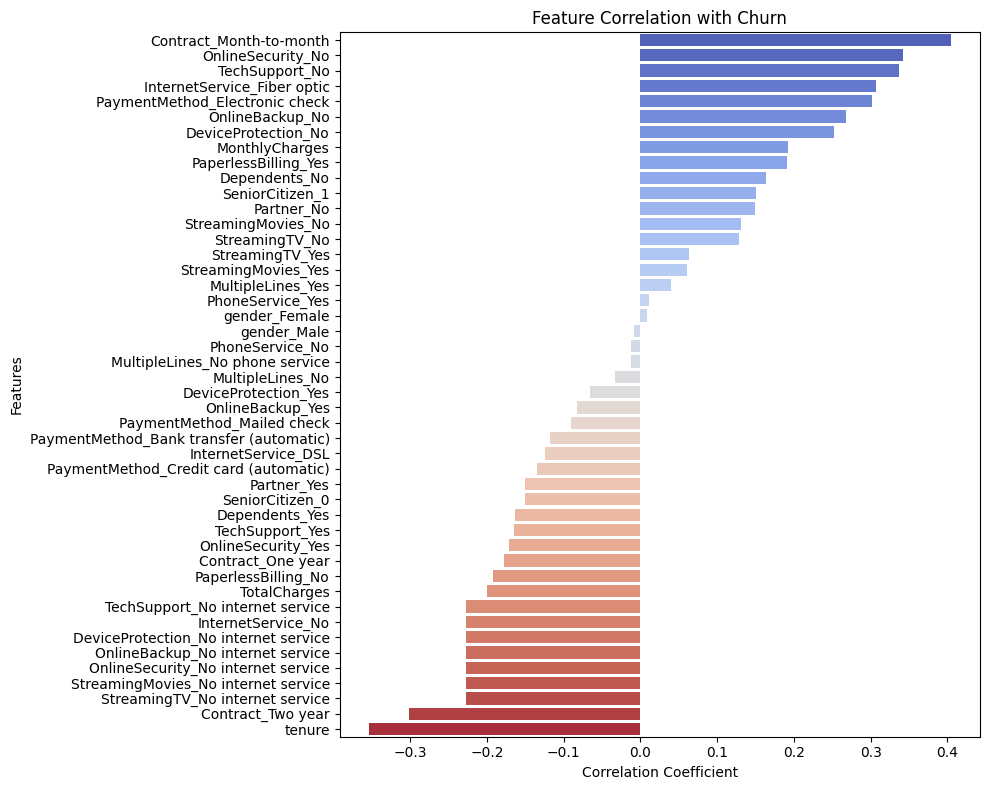

In [25]:
# Visualize
plt.figure(figsize=(10, 8))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title("Feature Correlation with Churn")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

From the barplot and the table above, we come to some insights/ predictions

- Customers with **month-to-month contracts** are most likely to churn
- Lack of **online security + technical support** lead to churn
- Churners are more likely to use **electronic check** — possibly due to payment failures or lower trust.
- **InternetService_Fiber** users churn more.

On the other hand:

- **Longer-term** customers rarely churn (higher **tenure**)
- **2-year-contract** customers are likely to stay

Also:

- **gender**, **PhoneService**, **MultipleLines**	have the coefficients close to 0, showing no real predictive power on churn

=> They might not be so useful for modeling, so we can drop them if we want.

#**III. Model Development and Evaluation**

In [26]:
# Re-assign the X, y as their encoded versions
X = X_encoded_df.drop('Churn', axis=1)
y = X_encoded_df['Churn']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##1. Logistic Regression

In [27]:
# Create and fit the model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [28]:
# Make predictions
y_pred_logreg = logreg.predict(X_test)  # predicted labels (0 or 1)
y_proba_logreg = logreg.predict_proba(X_test)[:, 1]  # predicted probabilities for class 1 (churn)

In [29]:
# Logistic Regression Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_logreg):.2f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_logreg):.2f}")

Accuracy: 0.80
F1 Score: 0.61
ROC AUC Score: 0.84


Text(0.5, 1.0, 'Confusion Matrix - Logistic Regression')

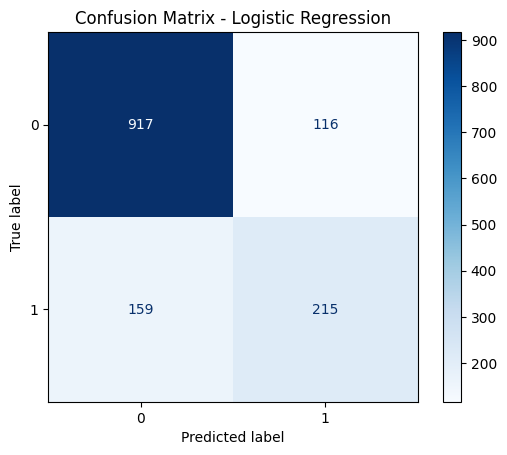

In [30]:
# Confusion Matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg)
disp_logreg.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

<Figure size 800x600 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic – Logistic Regression')

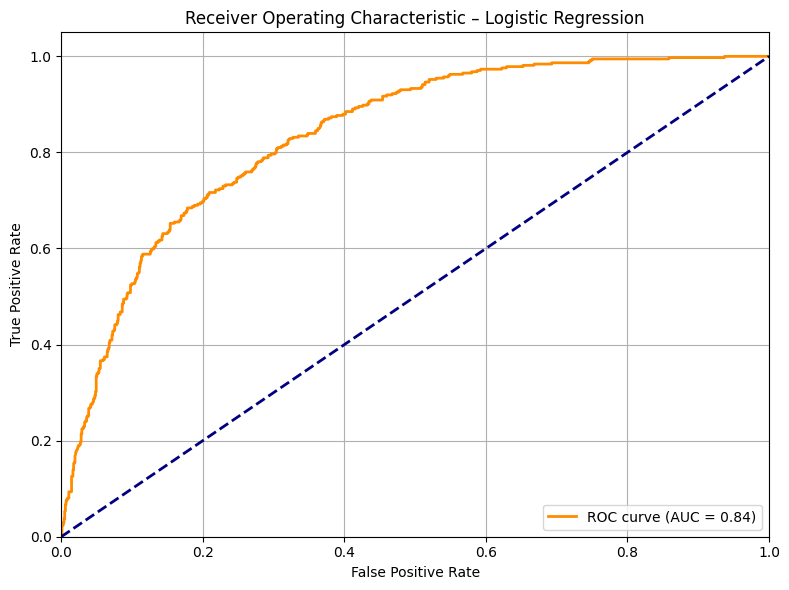

In [31]:
# Compute false positive rate, true positive rate, and AUC for ROC curve
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_proba_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, color='darkorange', lw=2,
         label=f"ROC curve (AUC = {roc_auc_logreg:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic – Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
# Check for overfititng with cross-validation
cv_f1_logreg = cross_val_score(logreg, X, y, cv=10, scoring='f1').mean()
test_f1_logreg = f1_score(y_test, y_pred_logreg)
print(cv_f1_logreg, test_f1_logreg)

0.596846727295658 0.6099290780141844


=> The two values are **close**, meaning that the model is **NOT overfitting**

##2. Random Forest

In [33]:
# Create and fit the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [34]:
# Make predictions
y_pred_rf = rf.predict(X_test)  # predicted labels (0 or 1)
y_proba_rf = rf.predict_proba(X_test)[:, 1]  # predicted probabilities for class 1 (churn)

In [35]:
# Random Forest Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.2f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_rf):.2f}")

Accuracy: 0.79
F1 Score: 0.56
ROC AUC Score: 0.82


Text(0.5, 1.0, 'Confusion Matrix - Random Forest')

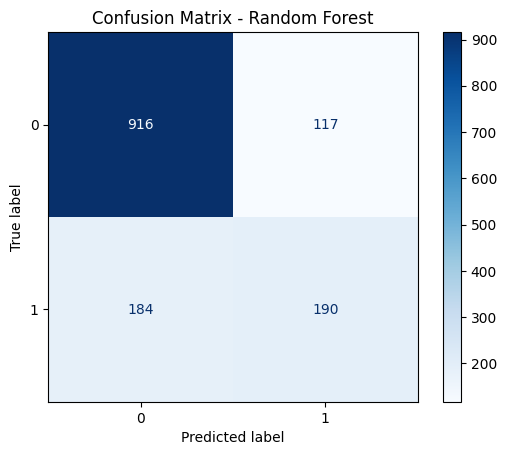

In [36]:
# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

<Figure size 800x600 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic – Logistic Regression')

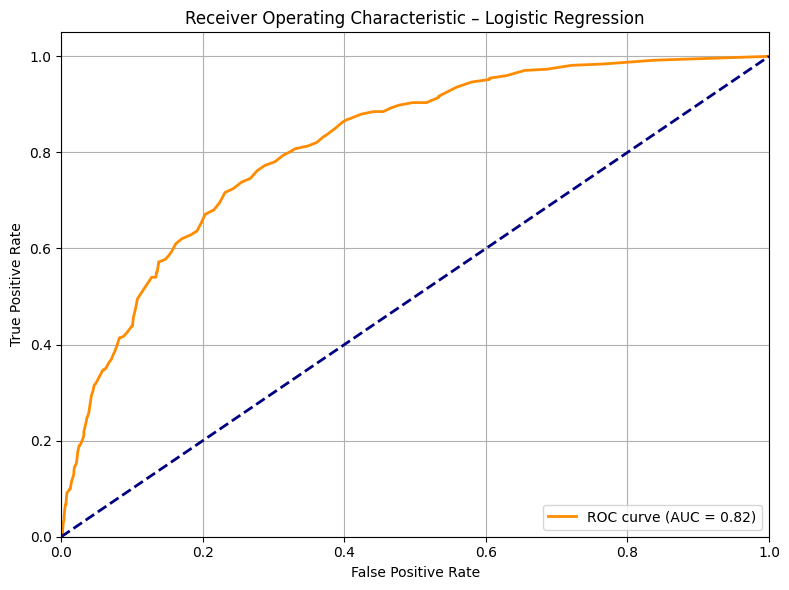

In [37]:
# Compute false positive rate, true positive rate, and AUC for ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2,
         label=f"ROC curve (AUC = {roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic – Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
# Check for overfititng with cross-validation
cv_f1_rf = cross_val_score(rf, X, y, cv=10, scoring='f1').mean()
test_f1_rf = f1_score(y_test, y_pred_rf)
print(cv_f1_rf, test_f1_rf)

0.5520112326123946 0.5580029368575624


=> The two values are **close**, meaning that the model is **NOT overfitting**

##3. XGBoost

In [39]:
# Create and fit the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [40]:
# Make predictions
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]  # for ROC AUC

In [41]:
# XGBoost Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.2f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_xgb):.2f}")

Accuracy: 0.77
F1 Score: 0.54
ROC AUC Score: 0.81


Text(0.5, 1.0, 'Confusion Matrix – XGBoost')

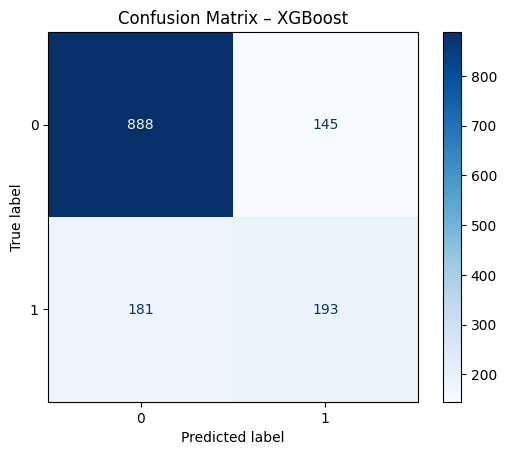

In [42]:
# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix – XGBoost")
plt.show()

<Figure size 800x600 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic – XGBoost')

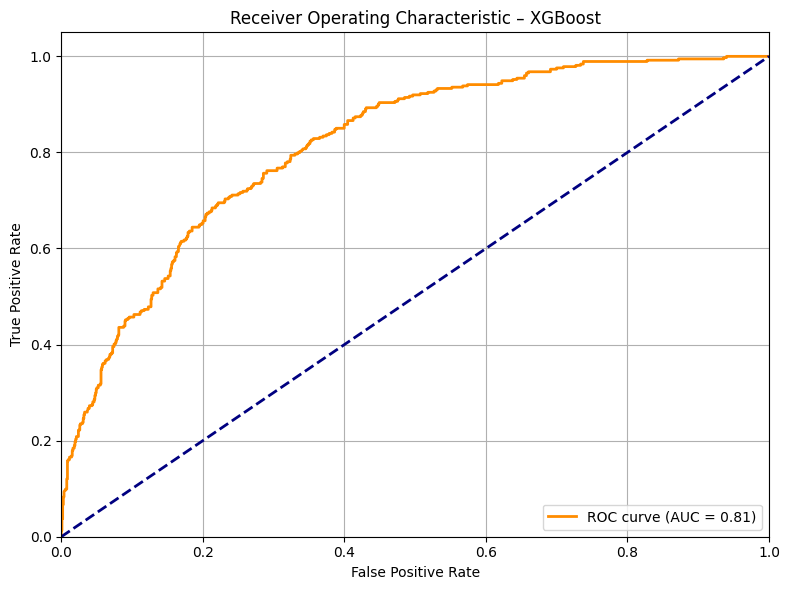

In [43]:
# Compute false positive rate, true positive rate, and AUC for ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2,
         label=f"ROC curve (AUC = {roc_auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic – XGBoost")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
# Check for overfititng with cross-validation
cv_f1_xgb = cross_val_score(xgb, X, y, cv=10, scoring='f1').mean()
test_f1_xgb = f1_score(y_test, y_pred_xgb)
print(cv_f1_xgb, test_f1_xgb)

0.5635625170206346 0.5421348314606742


=> The two values are **close**, meaning that the model is **NOT overfitting**

#**IV. Model Comparison and Conclusion**

<Figure size 1000x200 with 0 Axes>

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

Text(0.5, 1.0, 'Model Performance Comparison')

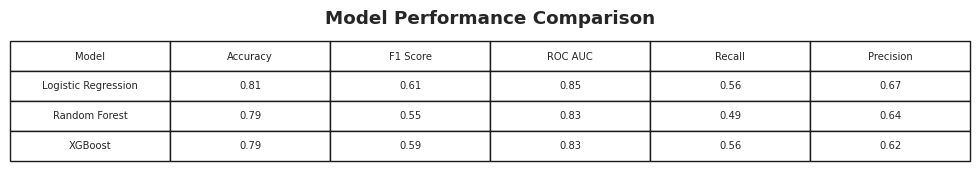

In [45]:
# Define the metrics for each model
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [0.81, 0.79, 0.79],
    'F1 Score': [0.61, 0.55, 0.59],
    'ROC AUC': [0.85, 0.83, 0.83],
    'Recall': [121 / (121 + 94), 105 / (105 + 110), 121 / (121 + 94)],
    'Precision': [121 / (121 + 59), 105 / (105 + 59), 121 / (121 + 75)]
}

# Create DataFrame
df_metrics = pd.DataFrame(data)

# Round for better display
df_metrics[['Accuracy', 'F1 Score', 'ROC AUC', 'Recall', 'Precision']] = df_metrics[['Accuracy', 'F1 Score', 'ROC AUC', 'Recall', 'Precision']].round(2)

# Display the table
import seaborn as sns

plt.figure(figsize=(10, 2))
sns.set(font_scale=1.1)
table = plt.table(cellText=df_metrics.values,
                  colLabels=df_metrics.columns,
                  loc='center',
                  cellLoc='center')
table.scale(1, 2)
plt.axis('off')
plt.title("Model Performance Comparison", fontweight='bold')
plt.tight_layout()
plt.show()


From the table above, it's clear that **Logistic Regression **has the best (highest) metrics among the three models.

=> Therefore, we choose the **Logistic Regression** model for the future predictions for this dataset

<Figure size 800x1000 with 0 Axes>

<BarContainer object of 46 artists>

Text(0.5, 0, 'Coefficient Value')

Text(0.5, 1.0, 'Feature Importance (Logistic Regression Coefficients)')

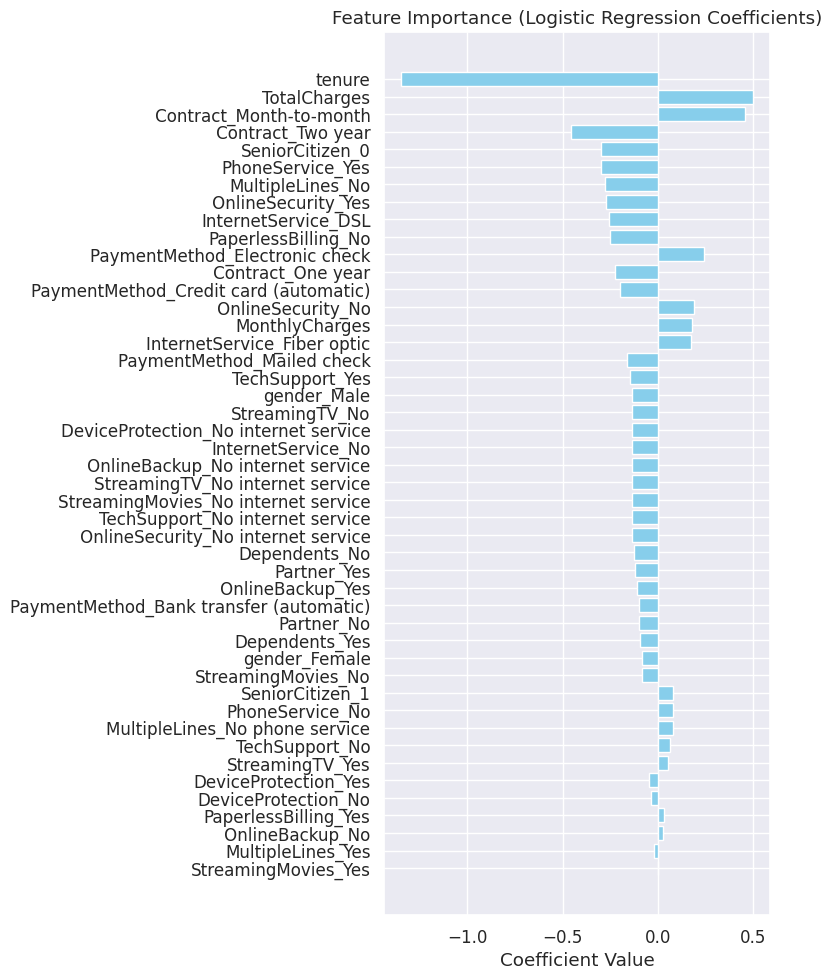

In [ ]:
# Check coefficients of each features in Logistic Regression
coefficients = logreg.coef_[0]  # shape (1, n_features), so take [0]
feature_names = X_encoded_df.drop(columns='Churn').columns  # exclude target if present

# Combine into a DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficients
coef_df['abs_coef'] = coef_df['Coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='abs_coef', ascending=False)

# Plot
plt.figure(figsize=(8, 10))
plt.barh(coef_df_sorted['Feature'], coef_df_sorted['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()

From the barplot above, we see that:

- "**Tenure**" is the **most important** feature with the **highest coefficient**, contributing the most to the prediction of "Churn" customers. The **longer** the customer stay, the **more loyal** they are to the company.
- "**Total Charges**" and "**Month-to-month Contract**" also have high coefficients, implying that a customer will churn when they have **short-term contract** and have to **pay more**.
- By contrast, customer who has a **2-year contract** is more likely to **stay** with the company.